# Sunspot prediction using  time series structured data
This notebook uses concepts from fastAIs DL1 course to estimate sunspot activity using a 2 layer fully connected neurel net. It demonstrates how to use time lags (or a sliding window) to feed series data into a neural ne to predict sunspot activity.  It shows how to predictions for 1 time step in the future as well as multiple steps in the future.<br>This notebook derives from this post https://medium.com/38th-street-studios/time-series-with-structured-deep-learning-e911c1ef9923

#run this to get jupyter extensions
!pip install https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tarball/master
!pip install jupyter_nbextensions_configurator
!jupyter contrib nbextension install --user
!jupyter nbextensions_configurator enable --user

In [258]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Get the data
comes from https://datamarket.com/data/set/22ti/zuerich-monthly-sunspot-numbers-1749-1983#!ds=22ti&display=line<br>
in ../data folder<br>

In [259]:
# get the data, first row [0] is column names
import pandas as pd
df = pd.read_csv("./data/sunspot/zuerich-monthly-sunspot-numbers.csv",header=0 )

# Initialize ( Full or partial dataset?, num_lags)

In [260]:
#uncomment below when using full dataset
df = df[:]

In [261]:
#create num_lags additional columns, for each row these columns will hold 
#SunspotNumbst-1, SunspotNumbst-2 etc
#used to create a list of the num_lags past correct observations to feed into the model
num_lags = 1

# View dataset

In [262]:
df.columns = ['Month', 'SunspotNumbs']

In [263]:
#view the data
df.tail()

,Month,SunspotNumbs
2815,1983-08,71.8
2816,1983-09,50.3
2817,1983-10,55.8
2818,1983-11,33.3
2819,1983-12,33.4


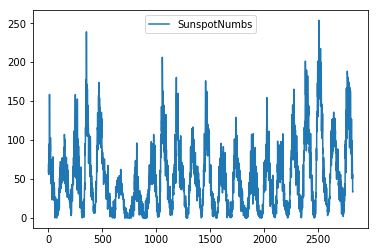

In [264]:
#view in a plot, looks like the cycle length is ~125 points (estimate by 500 points/4 peaks = 125 points use for num_lags)
import matplotlib.pyplot as plt
df.plot()

# convert date time
The last line in the csv file is a summary, please remove it before running this operation

In [265]:
from fastai.structured import *
from fastai.column_data import *
#Convert our date column to a pandas datetime Series
df["Date"] = pd.to_datetime(df["Month"], format='%Y-%m')
#Create date features
add_datepart(df,"Date")

In [266]:
#df.describe()

In [267]:
#see all the values, just need 2 year and month
df.columns.values

array(['Month', 'SunspotNumbs', 'Year', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
       'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed'],
      dtype=object)

In [268]:
df.dtypes

Month                 int64
SunspotNumbs        float64
Year                  int64
Week                  int64
Day                   int64
Dayofweek             int64
Dayofyear             int64
Is_month_end           bool
Is_month_start         bool
Is_quarter_end         bool
Is_quarter_start       bool
Is_year_end            bool
Is_year_start          bool
Elapsed               int64
dtype: object

In [269]:
# get rid of useless columns
df=df.drop(['Week', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Elapsed'],axis=1)

## These 2 cells do the same thing
Ones a bit easier to read and a bit slower

In [270]:
# %%timeit
# for i in range(1,num_lags+1):
#     df[f'lag_{i}'] = np.append([np.nan for j in range(0,i)],df['SunspotNumbs'])[:-i]

#for each row, convert all NANs to either Sunspot val or last lag_n that is not a NaN

In [271]:
%%timeit
df[f'lag_1'] =  df['SunspotNumbs'].shift(1)
for i in range(2,num_lags+1):
    df[f'lag_{i}'] = df[f'lag_{i-1}'].shift(1)

#for each row, convert all NANs to either Sunspot val or last lag_n that is not a NaN

154 µs ± 4.63 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Convert column types to category and float32

In [272]:
contin_vars = [f"lag_{i}" for i in range(1,num_lags+1)]
cat_vars = ["Year","Month","Dayofyear","Is_quarter_end","Is_quarter_start","Is_year_end","Is_year_start"]
dep = "SunspotNumbs"

#convert categorical to category type
for v in cat_vars: df[v] = df[v].astype('category').cat.as_ordered()
    
#make float32 since thats what pyTorch expects
for v in contin_vars: df[v] = df[v].astype('float32')

In [273]:
#df.dtypes

# Split dataframe to train, val, test

In [274]:
train_ratio = 0.8
val_ratio = 0.10
test_ratio = 0.1

#lets get a list of the indices of the entries I want in validation set
#its time series so make it at the end
numb_rows = len(df)

#get the validation portion of df
val_start = int(train_ratio*(float(numb_rows)))
val_end = int((train_ratio+ val_ratio)*(float(numb_rows)))
val_idx = list(range(val_start,val_end ))

#split out train-val df
df_trn_val = df[:val_end].copy()

#split out test df
df_test = df[val_end:].copy()

## operate on train and test sets
note that Im using the mapper and nas_trn_val from first proc_df to get the appropriate mean and std_dev and nas columns from trn_val set to use on test set 

In [275]:
#df, y, nas, mapper = proc_df(df_samp, 'SunspotNumbs', do_scale=True)
df_trn_val, yl_trn_val, nas_trn_val, mapper = proc_df(df=df_trn_val, y_fld='SunspotNumbs',do_scale=True)

#use the above mapper and nas_trn_val for normalization
df_test, yl_test, nas_test, _ = proc_df(df=df_test, y_fld='SunspotNumbs',do_scale=True, mapper =mapper, na_dict=nas_trn_val )

#first lets make sure we never take ln of 0 (-infinity) by adding a small value to y
yl_trn_val = np.log(yl_trn_val + 0.01)
yl_test = np.log(yl_test + 0.01)

In [276]:
yl_trn_val[0:5]

array([4.06062, 4.13693, 4.24864, 4.02016, 4.44277])

In [277]:
#nas will tell you the median value that is used to replace NaN's for every column with a NaN
# you can run the following command on column lag_1 to verify
#df_trn_val.lag_1.median()  (uncomment below to see median per lag column)

#nas_trn_val 
#df.lag_1.median()
#nas_test 

#note all the lag_i_na columns
#df_trn_val.head().T

#what does target look like
#len(y)
#yl_trn_val

In [278]:
#columns in test set
df_test.columns

Index(['Month', 'Year', 'Dayofyear', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'lag_1', 'lag_1_na'],
      dtype='object')

## Dataframe cleanup

In [279]:
#get rid of the lag_n_na fields
def dump_na_columns(df1):   
    for i in range(1,num_lags+1):
        try:
            df1.drop(f'lag_{i}_na',axis=1,inplace=True)
        except ValueError as e:
            print('ValueError:{0}'.format(e))
dump_na_columns(df_trn_val)
dump_na_columns(df_test)

In [280]:
print( "Rows in df_trn_val=" + str(len(df_trn_val)))
print( "Rows in df_test   =" + str(len(df_test)))

Rows in df_trn_val=2538
Rows in df_test   =282


## Adjust column types
Convert all categorical columns to 'category' and continuous variables to 'float32' (for pytorch)

In [281]:
#what kind are they now?

#df_trn_val.dtypes
#df_test.dtypes

In [282]:
for v in cat_vars: 
    df_trn_val[v] = df_trn_val[v].astype('category').cat.as_ordered()
    df_test[v] = df_test[v].astype('category').cat.as_ordered()

for v in contin_vars: 
    df_trn_val[v] = df_trn_val[v].astype('float32')
    df_test[v] = df_test[v].astype('float32')

## Verify no nulls

In [283]:
print( "Nulls in df_trn_val=" + str(df_trn_val.isnull().sum().sum()))
print( "Nulls in df_test   =" + str(df_test.isnull().sum().sum()))

print( "Rows in df_trn_val=" + str(len(df_trn_val)))
print( "Rows in df_test   =" + str(len(df_test)))

print( "Rows in yl_trn_val=" + str(len(yl_trn_val)))
print( "Rows in yl_test   =" + str(len(yl_test)))

Nulls in df_trn_val=0
Nulls in df_test   =0
Rows in df_trn_val=2538
Rows in df_test   =282
Rows in yl_trn_val=2538
Rows in yl_test   =282


# Save the data
side effect: df_test starts at index ~2300, the following will reset its index to 0 

In [284]:
PATH = "./data/SS_Data"

#needed for feather, do not add index column
df_trn_val.reset_index(drop = True,inplace = True)
df_test.reset_index(drop = True,inplace = True)

#save train and test dataframes
df_trn_val.to_feather(f'{PATH}/df_trn_val')
df_test.to_feather(f'{PATH}/df_test')

#save tran and test dependant nparray
np.save(f'{PATH}/yl_trn_val', yl_trn_val)    # .npy extension is added if not given
np.save(f'{PATH}/yl_test', yl_test)    

#save original
df.to_feather(f'{PATH}/df')

import pickle
output = open(f'{PATH}/mapper','wb')
pickle.dump(mapper, output)
output.close()
mapper
# np.save(f'{PATH}/mapper',mapper)
# mapper

DataFrameMapper(default=False, df_out=False,
        features=[(['lag_1'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['lag_1_na'], StandardScaler(copy=True, with_mean=True, with_std=True))],
        input_df=False, sparse=False)

# Reload the processed dataframes and the numpy target arrays

In [285]:
#reload
df_trn_val = pd.read_feather(f'{PATH}/df_trn_val')
df_test = pd.read_feather(f'{PATH}/df_test')

yl_trn_val  = np.load(f'{PATH}/yl_trn_val.npy')
yl_test  = np.load(f'{PATH}/yl_test.npy')

import pickle
input = open(f'{PATH}/mapper','rb')
mapper1 = pickle.load(input)
input.close()
mapper1

DataFrameMapper(default=False, df_out=False,
        features=[(['lag_1'], StandardScaler(copy=True, with_mean=True, with_std=True), {}), (['lag_1_na'], StandardScaler(copy=True, with_mean=True, with_std=True), {})],
        input_df=False, sparse=False)

In [286]:
#here is how you check the mean for a column
mapper.features[0][1].mean_

array([49.16016], dtype=float32)

# Create model data object

In [287]:
def inv_y(a): return np.exp(a)
def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())
def mse(y_pred, targ):
    targ = inv_y(targ)
    y_pred = inv_y(y_pred)
    return math.sqrt(((y_pred-targ)**2).mean())
max_log_y = np.max(yl_trn_val)
y_range = (0, max_log_y*1.2)

In [288]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df_trn_val, yl_trn_val.astype(np.float32), cat_flds=cat_vars, bs=16, test_df = df_test)
# md = ColumnarModelData.from_data_frame(PATH, val_idx, df_trn_val, yl_trn_val.astype(np.float32), cat_flds=cat_vars, bs=16)

In [289]:
#get categorical sizes, make sure you convert columns in cat_vars to type category before you run this 
#make sure you include all the years! including the possibilities from your test set see the df not df_trn_val below
# cat_sz = [(c, len(df_trn_val[c].cat.categories)+1) for c in cat_vars]
cat_sz = [(c, len(df[c].cat.categories)+1) for c in cat_vars]

emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [290]:
#len(df)
df.Dayofyear.unique()

[1, 32, 60, 91, 121, ..., 214, 245, 275, 306, 336]
Length: 22
Categories (22, int64): [1 < 32 < 60 < 61 ... 305 < 306 < 335 < 336]

In [291]:
# cat_sz[0] = (191, 50)
cat_sz

[('Year', 236),
 ('Month', 13),
 ('Dayofyear', 23),
 ('Is_quarter_end', 2),
 ('Is_quarter_start', 3),
 ('Is_year_end', 2),
 ('Is_year_start', 3)]

In [292]:
emb_szs

[(236, 50), (13, 7), (23, 12), (2, 1), (3, 2), (2, 1), (3, 2)]

/home/keith/fastai2/fastai/courses/ml1/fastai/column_data.py:101: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  for o in self.lins: kaiming_normal(o.weight.data)
/home/keith/fastai2/fastai/courses/ml1/fastai/column_data.py:101: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  for o in self.lins: kaiming_normal(o.weight.data)
/home/keith/fastai2/fastai/courses/ml1/fastai/column_data.py:103: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.outp.weight.data)


epoch      trn_loss   val_loss                               
    0      8.759023   17.444158 



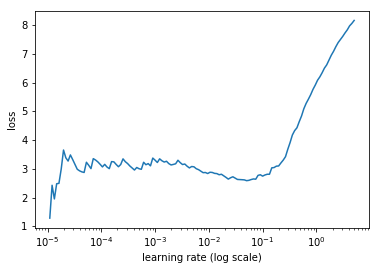

In [293]:
numb_continuous_columns = len(df_trn_val.columns)-len(cat_vars)
fully_connected_layers_sizes = [50,600]
fully_connected_layers_dropout = [0.001,0.01]
m = md.get_learner(emb_szs,numb_continuous_columns ,emb_drop = 0.04,out_sz= 1, szs = fully_connected_layers_sizes,
                   drops = fully_connected_layers_dropout, y_range=y_range)
m.lr_find()
m.sched.plot(1)

In [294]:
lr = 20e-5

# m.fit(lr, 2, metrics=[exp_rmspe,mse], cycle_len=1, cycle_mult=2)
m.fit(lr, n_cycle = 3, metrics=[exp_rmspe,mse], cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   exp_rmspe  mse              
    0      2.707482   0.838541   2.841596   48.531688 
    1      1.852458   0.622615   2.571395   37.1128          
    2      1.67839    0.48386    1.742885   41.60896         
    3      1.348968   0.479228   1.470705   36.646807        
    4      1.475219   0.513624   1.312477   31.148531        
    5      1.308113   0.494559   1.345398   31.675555        
    6      1.278507   0.531257   1.218969   28.623275        
    7      1.212257   0.525682   1.191674   29.563912        
    8      1.163363   0.617553   1.183467   36.163161        
    9      1.178669   0.64234    1.1739     37.307868        
    10     1.171325   0.660954   1.163674   38.197461        
    11     1.163776   0.638011   1.172649   37.587937        
    12     1.126402   0.630851   1.176533   37.612171        
    13     1.136137   0.630104   1.176448   37.560597        



[0.630103847976272, 1.1764479066532147, 37.56059736708637]

# Save model parameters

In [295]:
#saves it to wherever PATH points in original model object
m.save(f'val1')
m.load(f'val1')

# Run some predictions, first on the validation then on the test data


In [296]:
#calling predict will return predictions from the validation set
predictions_validation = m.predict()

The learner has never seen df_test values, so create a dataloader with these values to feed into the model for prediction.  The following will predict 1 step in the future based on the normalized dataset and the n (default 12) previous predictions.

In [297]:
#can do the below 3 if have seperate test set
#create ColumnarDataSet from DataFrame (df)
ctest = ColumnarDataset.from_data_frame(df_test,cat_flds=cat_vars)

# create DataLoader from ColumnarDataSet
dl_test = DataLoader(ctest)

# make predictions for DataLoader
predictions_test = m.predict_dl(dl_test)

#or this one for the built in one
# predictions_test = m.predict(is_test=True)

## Calculate final values for display

In [298]:
import matplotlib.pyplot as plt
def plot_data(val1=None,val2=None,val3=None,val4=None ):
    plt.rcParams['figure.figsize'] = [20, 10]
    if (val1 is not None):
        plt.plot(val1[0],label=val1[1])
    if (val2 is not None):
        plt.plot(val2[0],label=val2[1])
    if (val3 is not None):
        plt.plot(val3[0],label=val3[1])
    if (val4 is not None):
        plt.plot(val4[0],label=val4[1])
    plt.legend(loc='upper center');
    plt.show()

In [299]:
#actual
actual = np.append([np.exp(yl_trn_val)],[np.exp(yl_test)])

#validation(bunch of NaNs, val results, bunch of NaNs)
validation = np.append([  np.append([np.full(val_start,np.nan)],[np.exp(predictions_validation)])  ],[np.full(len(predictions_validation),np.nan)])

#test(bunch of NaNs,bunch of NaNs, val results )
test = np.append([np.full(len(df_trn_val),np.nan)],[np.exp(predictions_test)])

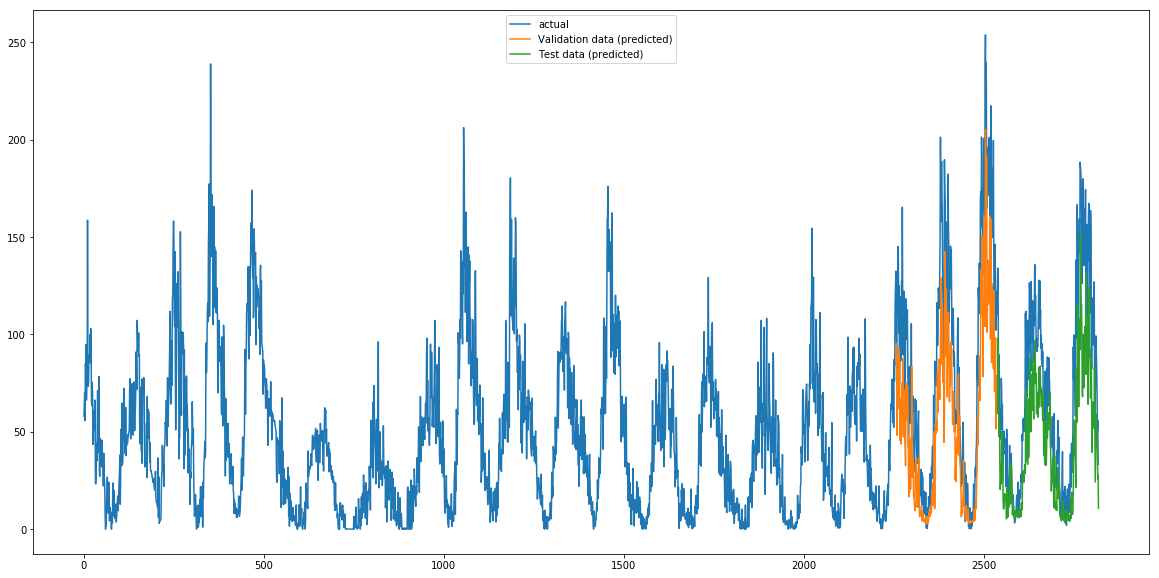

In [300]:
#lets see it
plot_data((actual, "actual"),(validation,'Validation data (predicted)'),(test,'Test data (predicted)'))

## Try long term predictions
What this means is that the lags in the dataset are replaced with what the model actually predicts, use this method to predict more than one datapoint in the future
This complicated the data as you must predict then scale, then add the scaled value to the lags for future predictions after every prediction.

In [327]:
#get a second test set for continuous testing
# df_test_cont = df[val_end:].copy()
starting_address = len(df)-100   #save this for later when resetting the prediction indeces
df_test_cont = df[starting_address:].copy()

starting_address = 0   #save this for later when resetting the prediction indeces
df_test_cont = df[:].copy()

# #this line is key, not sure why, but it is
df_test_cont.reset_index(drop = True,inplace = True)

# use the above mapper and nas_trn_val for normalization, do not scale though
df_test_cont, yl_test_cont,_ = proc_df(df=df_test_cont, y_fld='SunspotNumbs',do_scale=False, na_dict=nas_trn_val)

#get rid of the na columns in df test
dump_na_columns(df_test_cont)

#first lets make sure we never take ln of 0 (-infinity) by adding a small value to y
yl_test_cont = np.log(yl_test_cont + 0.01)

#notice the lag values are not normalized
df_test_cont.tail()

,Month,Year,Dayofyear,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,lag_1
2815,8,235,13,1,1,1,1,82.199997
2816,9,235,15,1,1,1,1,71.800003
2817,10,235,17,1,2,1,1,50.299999
2818,11,235,19,1,1,1,1,55.799999
2819,12,235,21,1,1,1,1,33.299999


## Create a prediction tracker object

In [334]:
from KP_lags import track_preds
continuous_preds = track_preds(df = df_test_cont, mapper=mapper, model = m, cat_vars=cat_vars, num_lags = num_lags)

In [335]:
print( "Nulls in continuous_preds.df=" + str(continuous_preds.df.isnull().sum().sum()))
continuous_preds.df.isna().any()

Nulls in continuous_preds.df=0


Month               False
Year                False
Dayofyear           False
Is_quarter_end      False
Is_quarter_start    False
Is_year_end         False
Is_year_start       False
lag_1               False
dtype: bool

In [336]:
values = {'lag_1': nas_trn_val['lag_1']}
continuous_preds.df.fillna(value = values,inplace =True)

In [337]:
#run it, it will loop, updating the lags in the dataset with the new predicted values for all rows
continuous_preds.run()

In [338]:
#continuous_preds.df.head(), notice that the lags are now all normalized
continuous_preds.df

,Month,Year,Dayofyear,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,lag_1
0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,-0.218198
1,2.0,1.0,2.0,1.0,1.0,1.0,1.0,-0.038433
2,3.0,1.0,3.0,1.0,1.0,1.0,1.0,0.104117
3,4.0,1.0,5.0,1.0,2.0,1.0,1.0,0.190745
4,5.0,1.0,7.0,1.0,1.0,1.0,1.0,0.361685
5,6.0,1.0,9.0,1.0,1.0,1.0,1.0,0.445647
6,7.0,1.0,11.0,1.0,2.0,1.0,1.0,0.407566
7,8.0,1.0,13.0,1.0,1.0,1.0,1.0,0.623746
8,9.0,1.0,15.0,1.0,1.0,1.0,1.0,0.530503
9,10.0,1.0,17.0,1.0,2.0,1.0,1.0,0.756278


In [339]:
#cont preds makes em all floats, no no no!
#they are categorical, fix it
continuous_preds.df.dtypes

Month               float32
Year                float32
Dayofyear           float32
Is_quarter_end      float32
Is_quarter_start    float32
Is_year_end         float32
Is_year_start       float32
lag_1               float32
dtype: object

## Plot

(2818,)


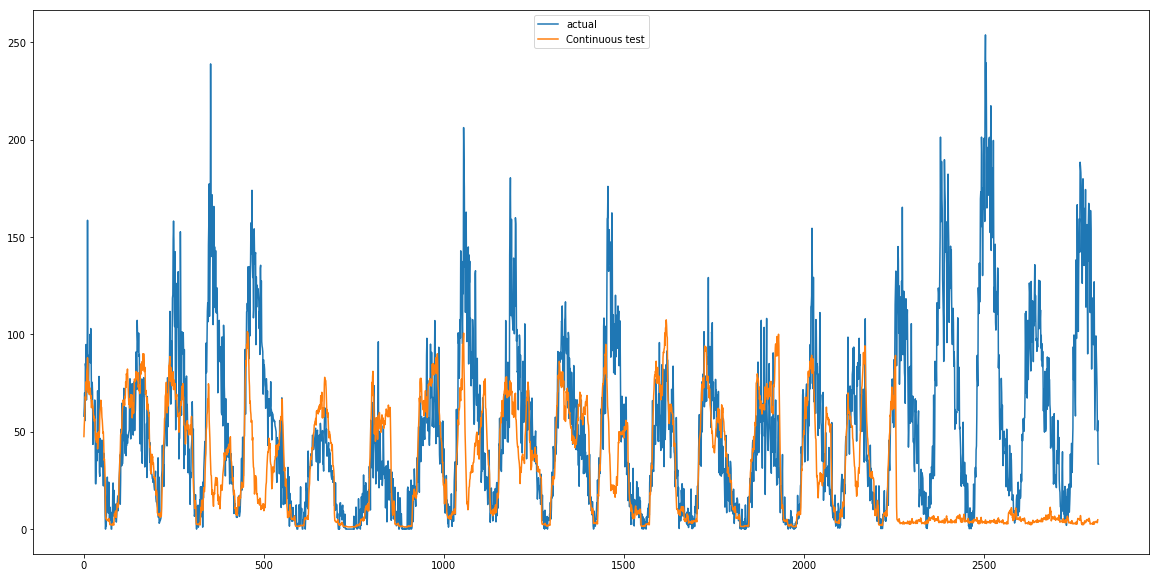

In [342]:
#expand these
test_cont = np.exp(continuous_preds.preds)

#reshape for plotting
test_cont = test_cont.reshape(len(test_cont))
print(test_cont.shape)

#lets see it actual verses calculated
plot_data((actual, "actual"),(test_cont,'Continuous test'))

# #lets see what the lags look like (make sure they match roughly the training data)
# plot_data((np.exp(continuous_preds.df.lag_1), "continuous_preds.df.lag_1"),(df_test_cont.lag_1,'df_test_cont.lag_1'))

## Playground
The following sections are for testing various bits

### The mapper contains mean and standard deviation for each column.  
The nas_trn_val contains the median for each column.  Columns of interest begin with lag_ . 

In [343]:
#each lag has its own mean and std deviation, the following is lag_1 mean and variance
mapper.features[0][1].mean_
mapper.features[0][1].var_

array([1801.0867], dtype=float32)

In [344]:
def scale_by_lag(lag,val):
    #lags start at 1 but are 0 indexed, so sub 1 from lag number
    #the 1 is the location of the StandardScaler in the tuple
    return (val - mapper.features[lag-1][1].mean_)/np.sqrt(mapper.features[lag-1][1].var_)

In [345]:
mapper.features[0][0][0]

'lag_1'

In [346]:
#lets verify that it all works, 2nd row lag_1 is 58 from above when we scale it, it should be .3524
val_ = scale_by_lag(lag = 1,val=58)
val_

array([0.20829], dtype=float32)

In [347]:
# ilen = len(df_test)
# ilen
# df_test.iloc[ilen-1]
df_trn_val.iloc[0]

Month                     1
Year                      1
Dayofyear                 1
Is_quarter_end            1
Is_quarter_start          2
Is_year_end               1
Is_year_start             2
lag_1              -1.18578
Name: 0, dtype: object

### verify operations

In [348]:
#get a single row from the test dataframe
type(df_test.iloc[[0]])

pandas.core.frame.DataFrame

In [349]:
df_test.iloc[0:2,:].head()

,Month,Year,Dayofyear,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,lag_1
0,7,212,12,1,2,1,1,1.438289
1,8,212,14,1,1,1,1,1.709264


In [350]:
#verify simple operation
one_row = ColumnarDataset.from_data_frame(df_test.iloc[0:2,:],cat_flds=cat_vars)
one_row_test = DataLoader(one_row)
one_row_test
one_row_test = m.predict_dl(one_row_test)
one_row_test[0][0]

4.0870934